# Detection de phishing URLs

### Import des librairies 

In [3]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
from sklearn.feature_extraction.text import CountVectorizer
import whois
import dns.resolver
import requests
from googlesearch import search
from urllib.parse import urlparse

## Exploration du dataset

In [4]:
df = pd.read_csv('data/dataset.csv')
df.head()

,domain,label
0,http://sprint.com/business/solutions/mobility_...,0.0
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0
2,http://web.de/magazine/digital/sicher-im-netz/...,0.0
3,www.wired.com/science/discoveries/news/1999/08...,0.0
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.0


In [5]:
df.shape

(120990, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120990 entries, 0 to 120989
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   domain  120990 non-null  object 
 1   label   120990 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


### Nombre de label (Phishing et legitime) 

label
0.0    92680
1.0    28310
Name: count, dtype: int64


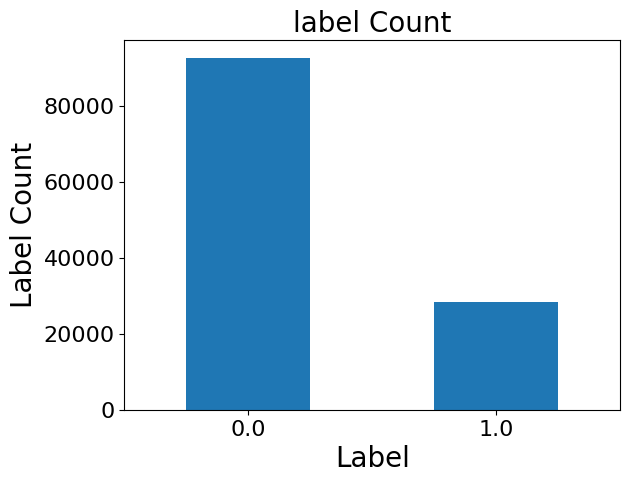

In [7]:
count_labels = df['label'].value_counts()
print(count_labels)
count_labels.plot(kind='bar', fontsize=16)
plt.title("label Count" , fontsize=20)
plt.xticks(rotation='horizontal')
plt.xlabel("Label", fontsize=20)
plt.ylabel("Label Count", fontsize=20)

plt.show()

## Feature engineering & visualisation des données

Ici nous allons essayer d'obtenir des caractéristiques numériques à partir des URL et observer leur distribution à travers de graphiques 

In [8]:
def add_carcteristics(data):
    result = data.copy()
    
    result["nbr_https"]= result['domain'].apply(lambda i : i.count('https'))
    
    result["nbr_http"]= result['domain'].apply(lambda i : i.count('http'))
    
    result["nbr_doubleSlash"]= result['domain'].apply(lambda i : i.count('//'))
    
    result["nbr_www"]= result['domain'].apply(lambda i : i.count('www'))
    
    result["nbr_slash"]= result['domain'].apply(lambda i : i.count('/'))
    
    result["nbr_@"]= result['domain'].apply(lambda i : i.count('@'))
    
    result["nbr_-"]= result['domain'].apply(lambda i : i.count('-'))
    
    result["nbr_?"]= result['domain'].apply(lambda i : i.count('?'))
    
    result["nbr_%"]= result['domain'].apply(lambda i : i.count('%'))
    
    result["nbr_="]= result['domain'].apply(lambda i : i.count('='))
    
    result["nbr_."]= result['domain'].apply(lambda i : i.count('.'))
    
    result["length"] = result['domain'].apply(lambda i : len(i))
    
    return result
    

In [9]:
df_carc = add_carcteristics(df)
df_carc

,domain,label,nbr_https,nbr_http,nbr_doubleSlash,nbr_www,nbr_slash,nbr_@,nbr_-,nbr_?,nbr_%,nbr_=,nbr_.,length
0,http://sprint.com/business/solutions/mobility_...,0.0,0,1,1,0,6,0,0,1,0,1,2,105
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0,0,0,0,0,3,0,0,0,0,0,3,37
2,http://web.de/magazine/digital/sicher-im-netz/...,0.0,0,1,1,0,6,0,10,0,0,0,1,131
3,www.wired.com/science/discoveries/news/1999/08...,0.0,0,0,0,1,6,0,0,0,0,0,2,52
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.0,0,0,0,0,3,0,1,0,0,0,3,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120985,http://emgn.com/tv/watch-just-be-glad-these-di...,0.0,0,1,1,0,5,0,15,0,0,0,1,96
120986,www.minisoftindia.com/entourage,0.0,0,0,0,1,1,0,0,0,0,0,2,31
120987,https://medium.com/@VPOTUS/the-vice-president-...,0.0,1,1,1,0,4,1,18,1,0,1,1,162
120988,libguides.com,0.0,0,0,0,0,0,0,0,0,0,0,1,13


### Visualisation de certaines caractéristiques

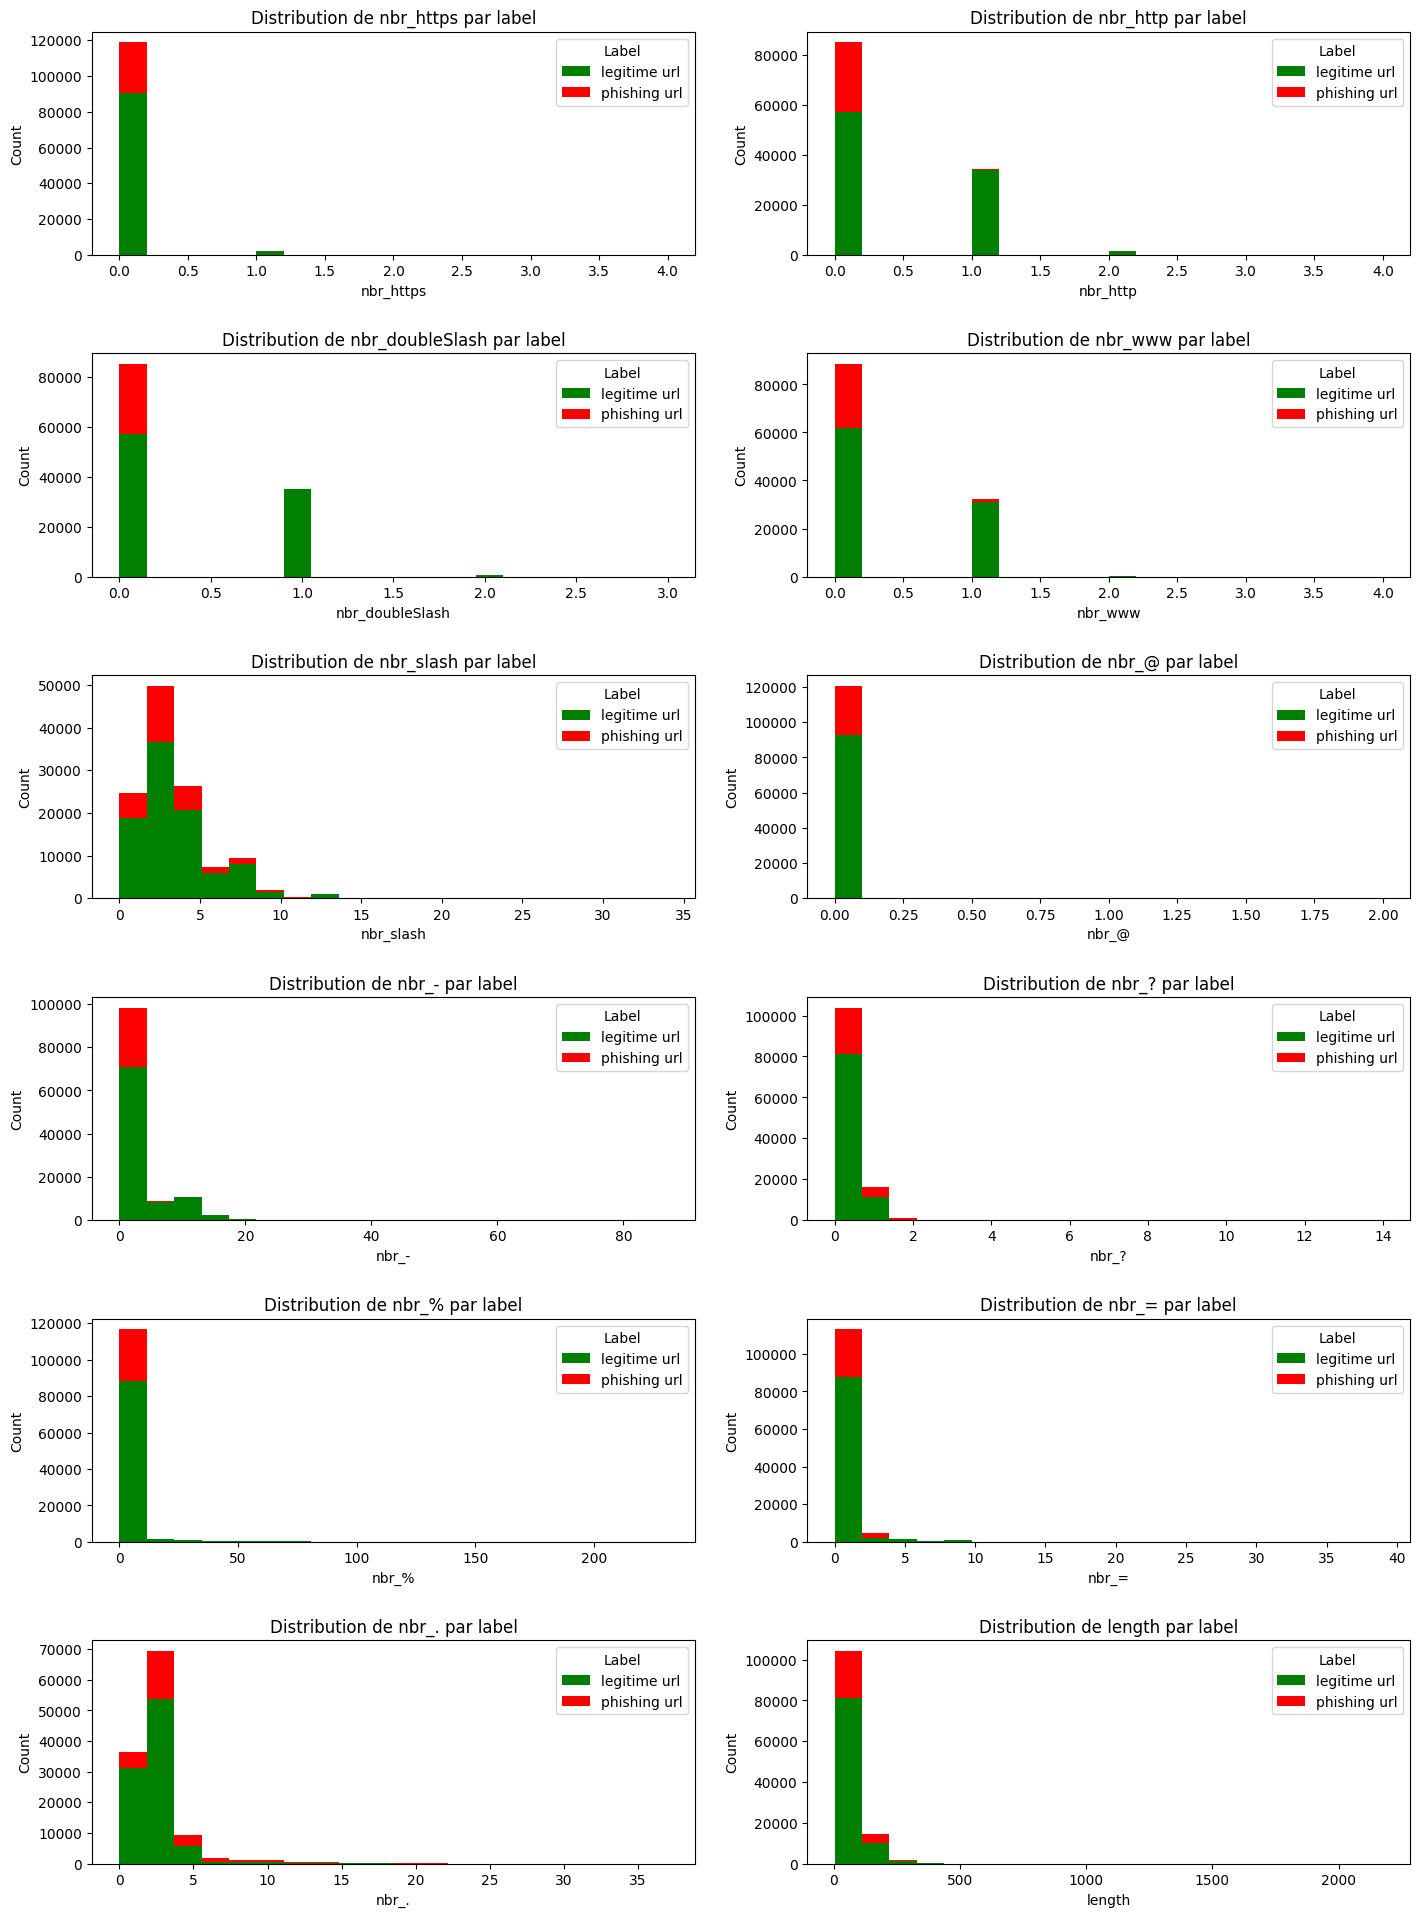

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5)

axes = axes.flatten()

# Parcourir chaque caractéristique et créer un graphique en barres
for i, column in enumerate(df_carc.columns[2:]):
    ax = axes[i]
    ax.hist([df_carc[df_carc['label'] == 0.0][column], df_carc[df_carc['label'] == 1.0][column]], 
            bins=20, stacked=True, label=['legitime url', 'phishing url'], color=['green', 'red'])
    
    ax.set_title(f'Distribution de {column} par label')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.legend(title='Label')
    if column == 'length_dmn':
        plt.xlim(0, 300)

# Supprimer le dernier subplot vide
#fig.delaxes(axes[-1])

# Afficher la figure
plt.show()


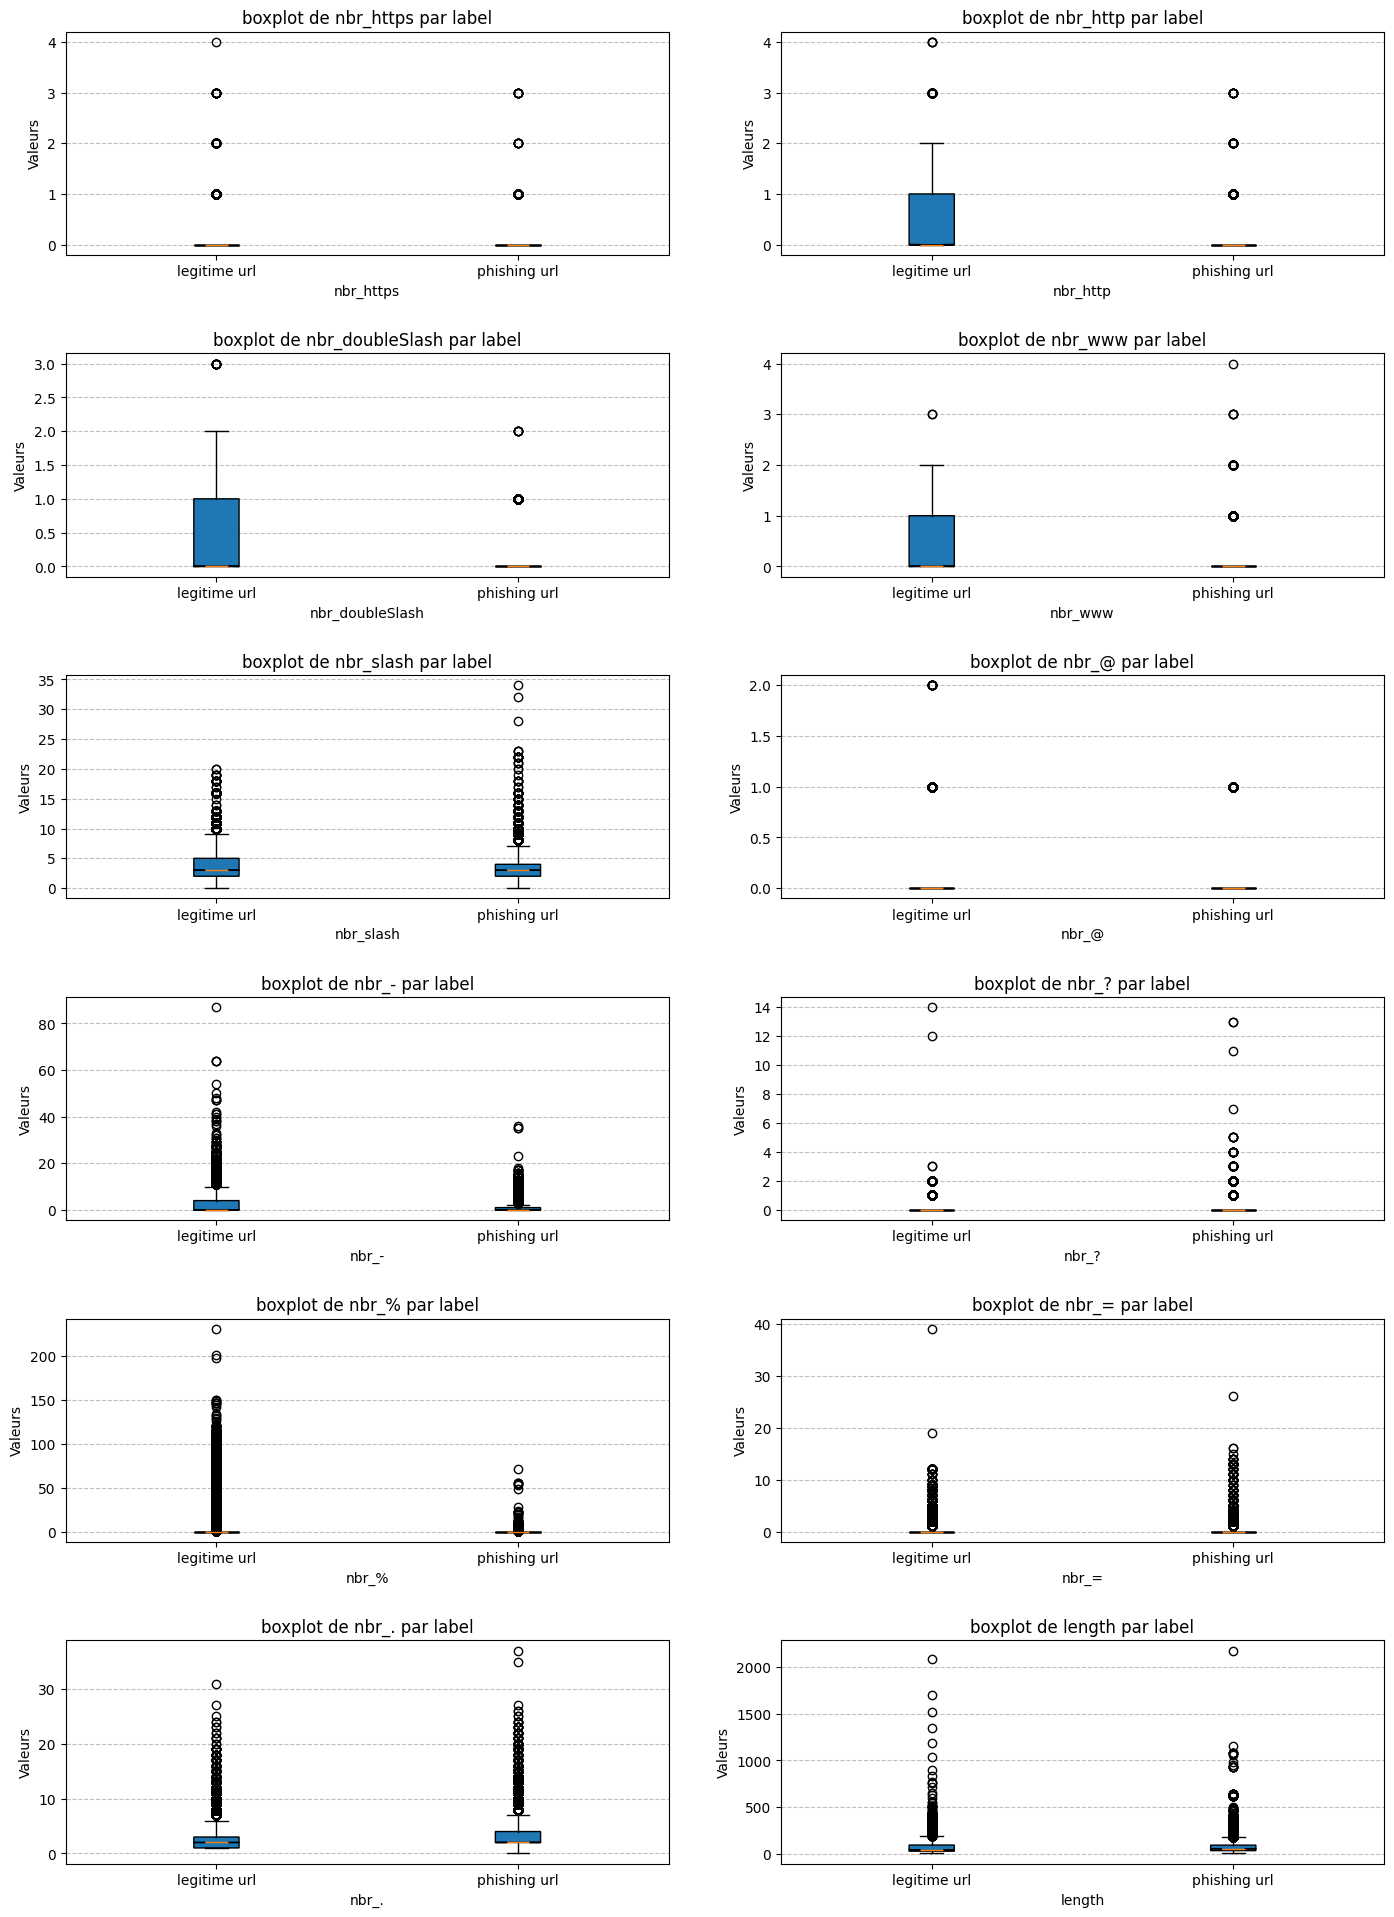

In [84]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5)

axes = axes.flatten()

# Parcourir chaque caractéristique et créer un graphique en boîte à moustache
for i, column in enumerate(df_carc.columns[2:14]):
    ax = axes[i]
    data = [df_carc[df_carc['label'] == 0.0][column], df_carc[df_carc['label'] == 1.0][column]]
    ax.boxplot(data, patch_artist=True, notch=True)
    
    ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.5)
    ax.set_title(f'boxplot de {column} par label')
    ax.set_xlabel(column)
    ax.set_ylabel('Valeurs')
    ax.set_xticklabels(['legitime url', 'phishing url'])
    if column == 'length_dmn':
        ax.set_xlim(0, 300)

# Afficher la figure
plt.show()

J'ai affiché les distributions ensuite les boites à moustache pour voir comment les données sont reparti en fonction d'une caractéristique. (certaines d'entre elles sont plus facilement analysables à l'aide d'un histogramme d'autre à l'aide d'une boxplot)

### Nuage de mots contenu dans le domain 

A présent, nous allons visualiser les mots les plus présents dans les url légitimes et de phishing pour ensuite créer une caractéristique qui se basera sur les mots pour savoir si l'url contient un mot suspect 

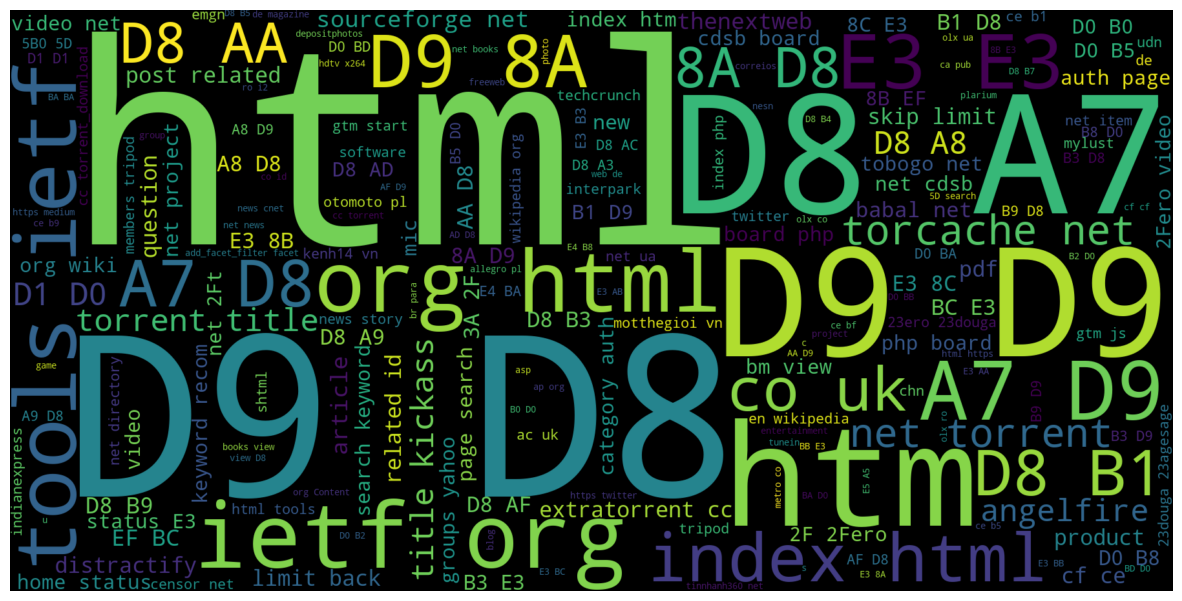

In [11]:
df_legitime = df[df.label==0.0]
legitime_domain = " ".join(i for i in df_legitime.domain)
wcloud = WordCloud(width=1800, height=900).generate(legitime_domain)
plt.figure(figsize=(15,15))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

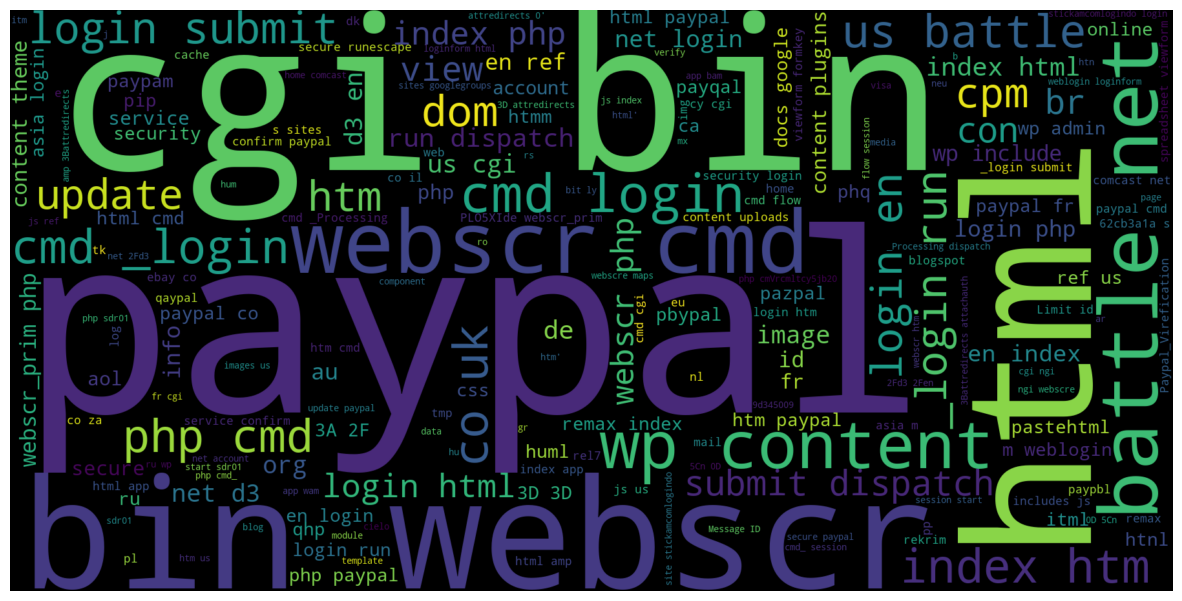

In [12]:
df_phishing = df[df.label==1.0]
phishing_domain = " ".join(i for i in df_phishing.domain)
wcloud = WordCloud(width=1800, height=900).generate(phishing_domain)
plt.figure(figsize=(15,15))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
def phishing_words(data):
    result = re.search('pay|pal|battle|wp|cgi|login|webscr|cmd|bin|submit|bank|secure|update|account|password',data) 
    
    if result:
        return 1
    else:
        return 0

In [14]:
df_carc["phishing_words"] = df['domain'].apply(lambda i : phishing_words(i))

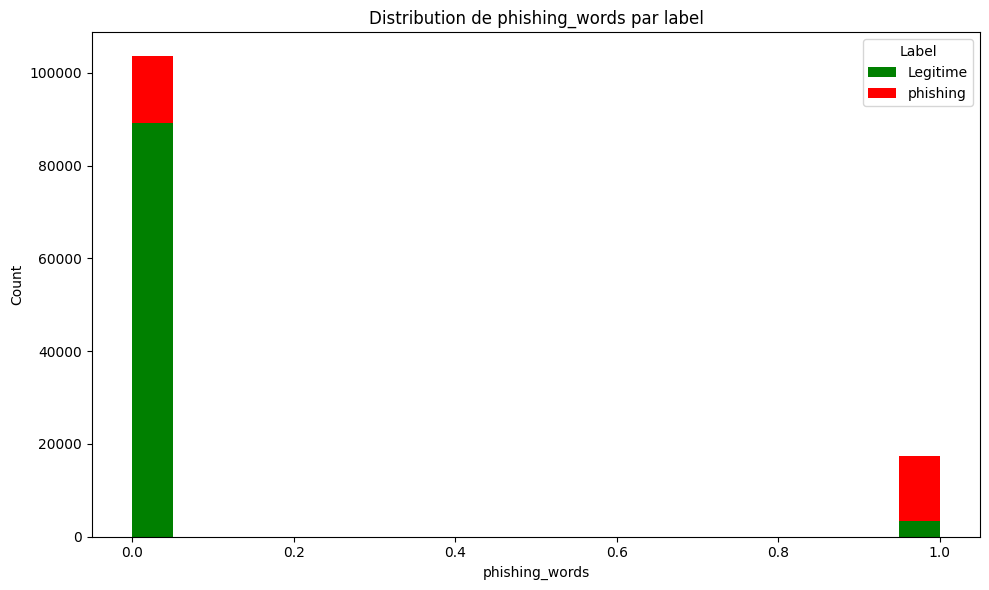

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["phishing_words"], df_carc[df_carc['label'] == 1]["phishing_words"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de phishing_words par label')
ax.set_xlabel("phishing_words")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [16]:
def detect_ip_in_url(url: str) -> int:
    ip_pattern = re.compile(r'http[s]?://(?:\d{1,3}\.){3}\d{1,3}')
    
    if ip_pattern.search(url):
        return 1
    else:
        return 0

In [17]:
df_carc["ip_address"] = df['domain'].apply(lambda i : detect_ip_in_url(i))

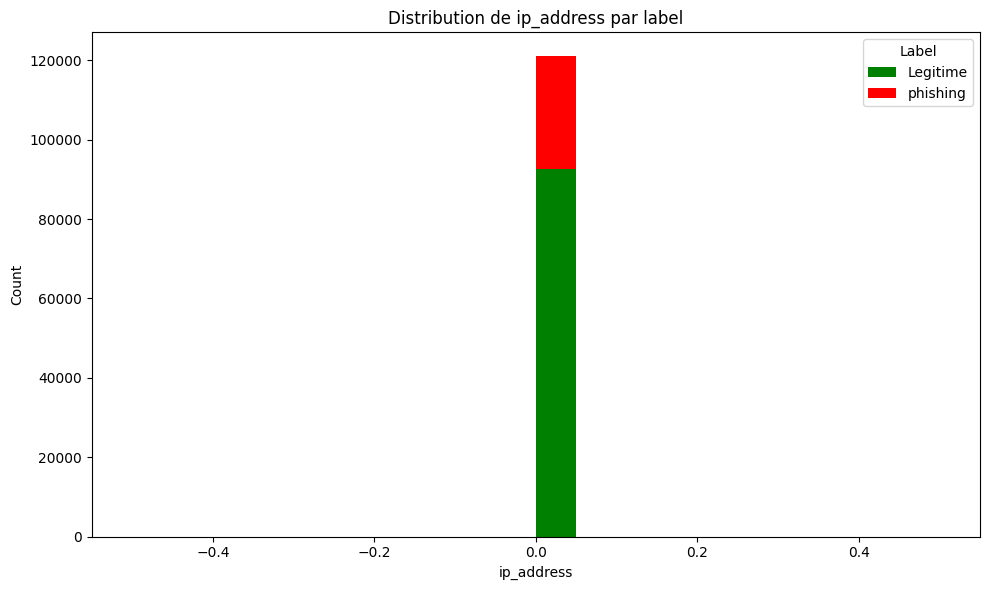

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["ip_address"], df_carc[df_carc['label'] == 1]["ip_address"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de ip_address par label')
ax.set_xlabel("ip_address")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [19]:
def check_google_index(url):
    try:
        search_results = search(url, num_results=5)
        if search_results : 
            return 1 
        else :
            return 0
    except Exception as e:
        print(f"Error occurred: {e}")
        return False

In [20]:
df_carc['G_index'] = df['domain'].apply(lambda i : check_google_index(i))

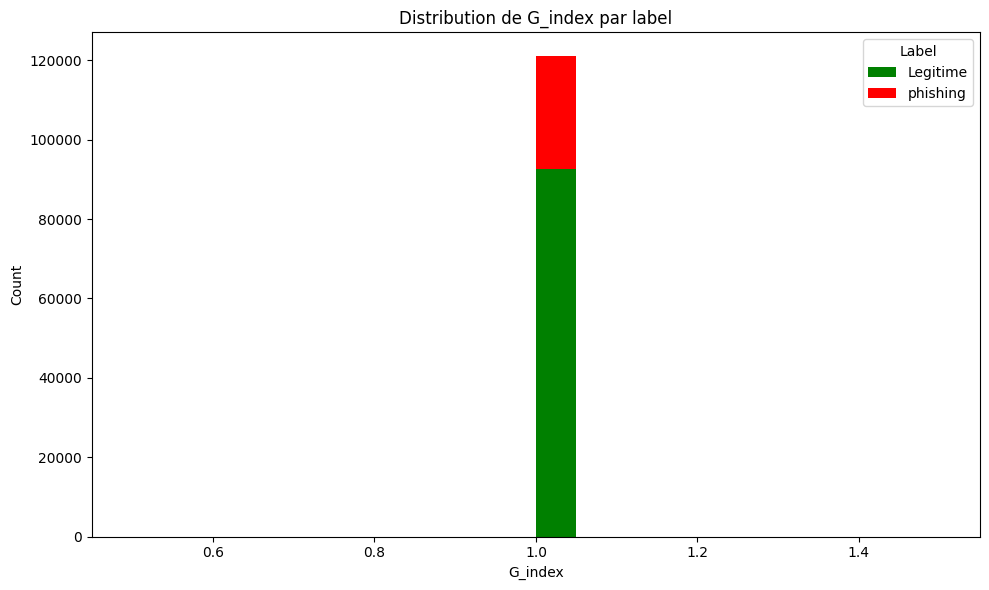

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["G_index"], df_carc[df_carc['label'] == 1]["G_index"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de G_index par label')
ax.set_xlabel("G_index")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [22]:
def contains_digits(url):
    for char in url:
        if  char.isdigit() :
            return 1
    
    return 0

In [23]:
contains_digits(df.domain[0])

0

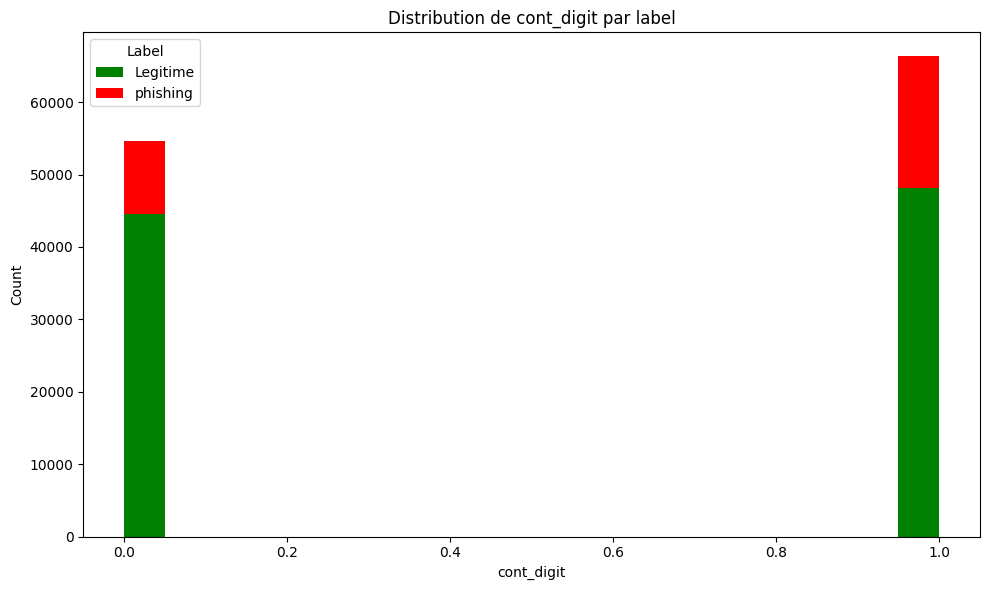

In [24]:
df_carc['cont_digit'] = df['domain'].apply(lambda i : contains_digits(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["cont_digit"], df_carc[df_carc['label'] == 1]["cont_digit"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de cont_digit par label')
ax.set_xlabel("cont_digit")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [25]:
def domain_length(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return len(domain)

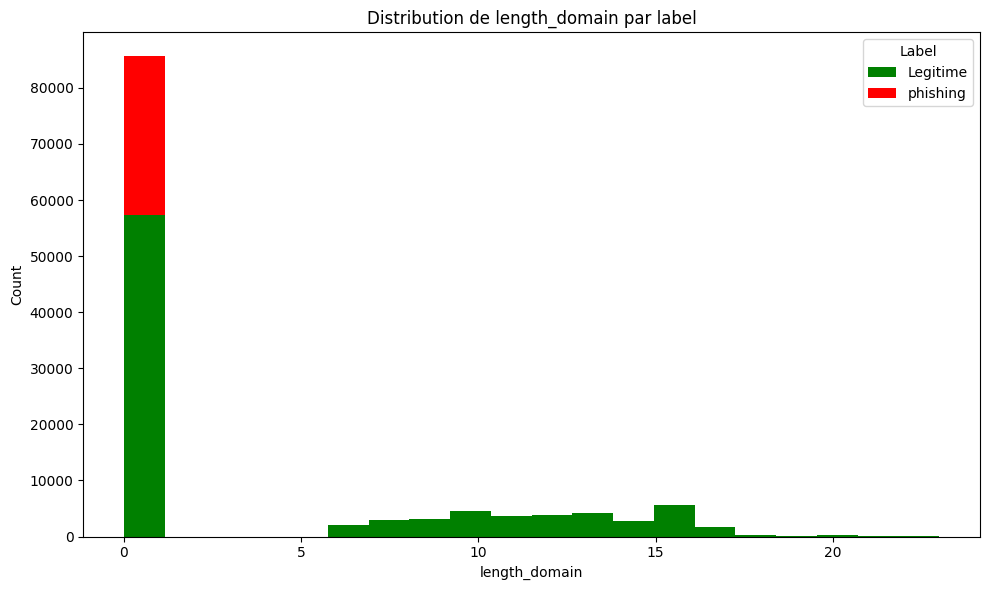

In [86]:
df_carc['length_domain'] = df['domain'].apply(lambda i : domain_length(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["length_domain"], df_carc[df_carc['label'] == 1]["length_domain"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de length_domain par label')
ax.set_xlabel("length_domain")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

/var/folders/28/b7kmqjl93m5_p5m4k7pkb2bm0000gn/T/ipykernel_5803/2960266118.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Label')


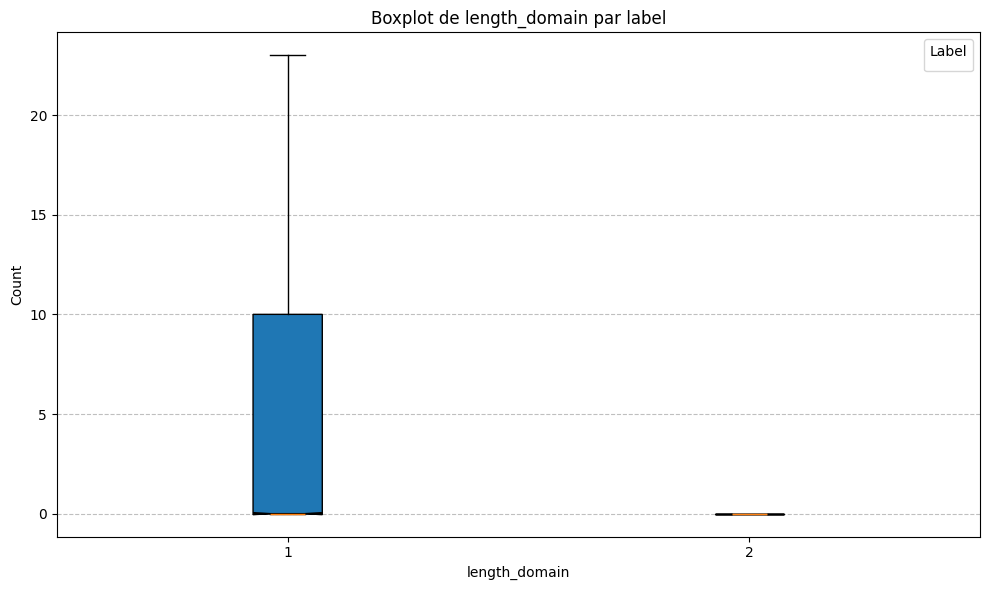

In [89]:
df_carc['length_domain'] = df['domain'].apply(lambda i : domain_length(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([df_carc[df_carc['label'] == 0]["length_domain"], df_carc[df_carc['label'] == 1]["length_domain"]], patch_artist=True, notch=True)

ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.5)
ax.set_title(f'Boxplot de length_domain par label')
ax.set_xlabel("length_domain")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [27]:
def is_shortened_url(url):
    shorteners = ['bit.ly', 'goo.gl', 'shorte.st', 'go2l.ink', 'x.co', 'ow.ly', 't.co', 'tinyurl', 'tr.im', 'is.gd', 'cli.gs', 
    'yfrog.com', 'migre.me', 'ff.im', 'tiny.cc', 'url4.eu', 'twit.ac', 'su.pr', 'twurl.nl', 'snipurl.com', 
    'short.to', 'BudURL.com', 'ping.fm', 'post.ly', 'Just.as', 'bkite.com', 'snipr.com', 'fic.kr', 'loopt.us', 
    'doiop.com', 'short.ie', 'kl.am', 'wp.me', 'rubyurl.com', 'om.ly', 'to.ly', 'bit.do', 't.co', 'lnkd.in', 
    'db.tt', 'qr.ae', 'adf.ly', 'goo.gl', 'bitly.com', 'cur.lv', 'tinyurl.com', 'ow.ly', 'bit.ly', 'ity.im', 
    'q.gs', 'is.gd', 'po.st', 'bc.vc', 'twitthis.com', 'u.to', 'j.mp', 'buzurl.com', 'cutt.us', 'u.bb', 
    'yourls.org', 'x.co', 'prettylinkpro.com', 'scrnch.me', 'filoops.info', 'vzturl.com', 'qr.net', '1url.com', 
    'tweez.me', 'v.gd', 'tr.im', 'link.zip.net']

    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    for short in shorteners :
        if short in url :
                return 1

    return 0
    
        

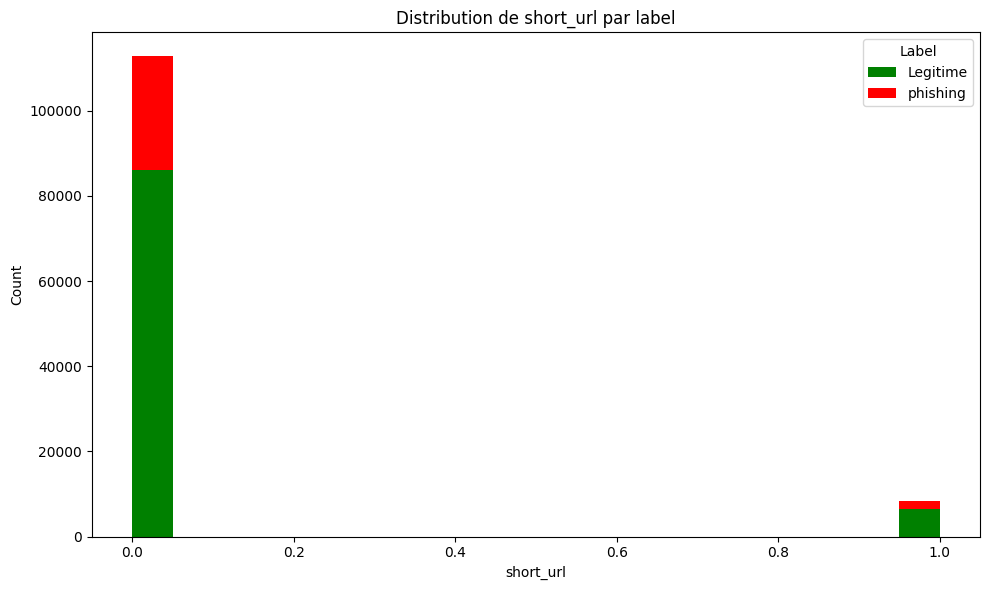

In [28]:
df_carc['short_url'] = df['domain'].apply(lambda i : is_shortened_url(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["short_url"], df_carc[df_carc['label'] == 1]["short_url"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de short_url par label')
ax.set_xlabel("short_url")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [29]:
def bad_url(url):
    result =re.search(str(urlparse(url).hostname), url)
    if result:
        return 1
    else:
        return 0

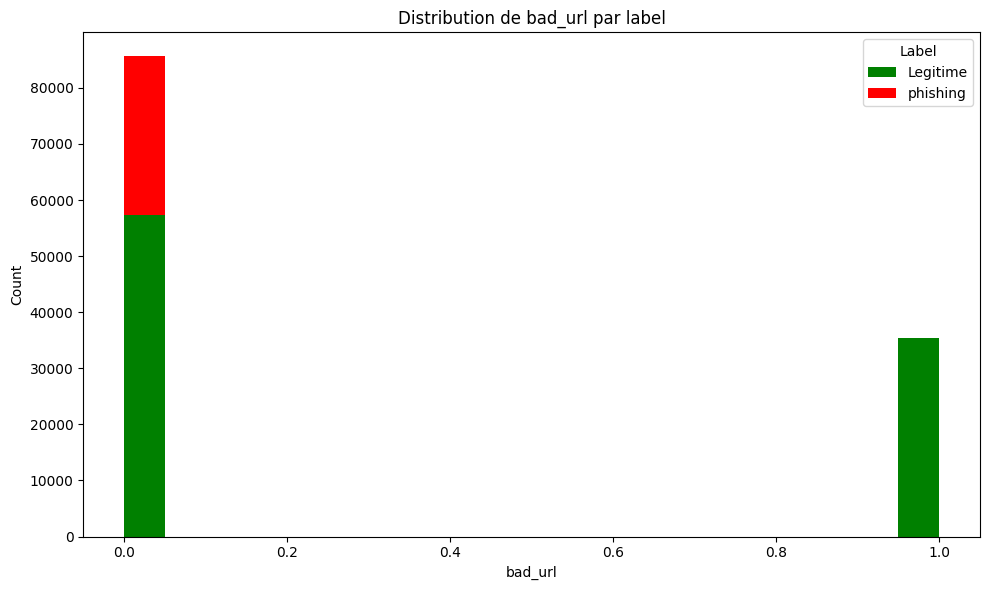

In [30]:
df_carc['bad_url'] = df['domain'].apply(lambda i : bad_url(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["bad_url"], df_carc[df_carc['label'] == 1]["bad_url"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de bad_url par label')
ax.set_xlabel("bad_url")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [31]:
def count_special_characters(url):
    special_characters = re.findall(r'[^a-zA-Z0-9]', url)
    return len(special_characters)

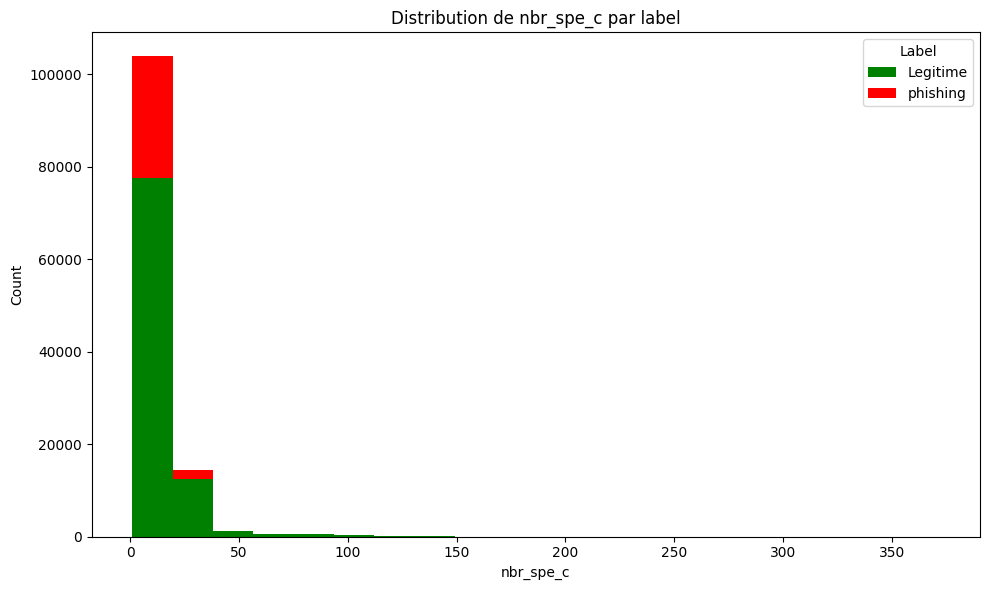

In [32]:
df_carc['nbr_spe_c'] = df['domain'].apply(lambda i : count_special_characters(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["nbr_spe_c"], df_carc[df_carc['label'] == 1]["nbr_spe_c"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de nbr_spe_c par label')
ax.set_xlabel("nbr_spe_c")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [33]:
def contains_hex_characters(url):
    hex_characters = re.findall(r'[0-9a-fA-F]', url)
    return 1 if hex_characters else 0

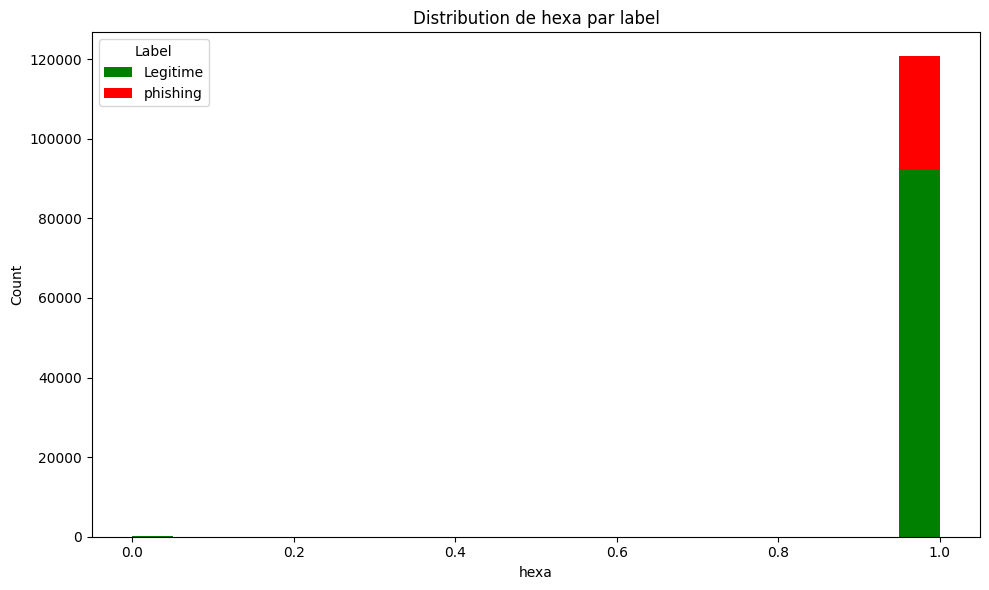

In [34]:
df_carc['hexa'] = df['domain'].apply(lambda i : contains_hex_characters(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["hexa"], df_carc[df_carc['label'] == 1]["hexa"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de hexa par label')
ax.set_xlabel("hexa")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

In [35]:
def count_query_parameters(url):
    parsed_url = urlparse(url)
    query = parsed_url.query
    if query:
        return len(query.split('&'))
    else:
        return 0

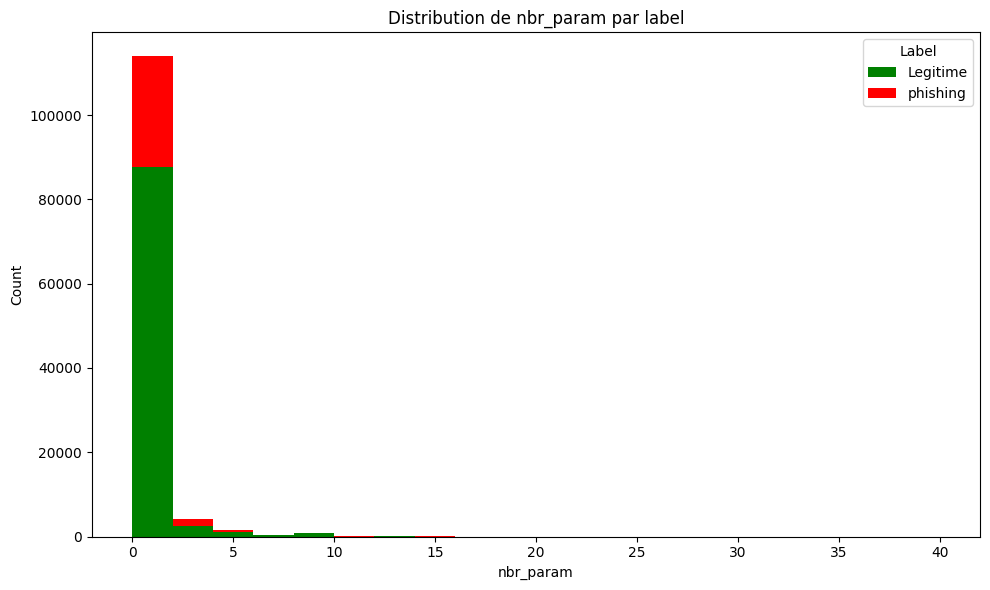

In [36]:
df_carc['nbr_param'] = df['domain'].apply(lambda i : count_query_parameters(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([df_carc[df_carc['label'] == 0]["nbr_param"], df_carc[df_carc['label'] == 1]["nbr_param"]], 
        bins=20, stacked=True, label=['Legitime', 'phishing'], color=['green', 'red'])

ax.set_title(f'Distribution de nbr_param par label')
ax.set_xlabel("nbr_param")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

/var/folders/28/b7kmqjl93m5_p5m4k7pkb2bm0000gn/T/ipykernel_5803/1293537129.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Label')


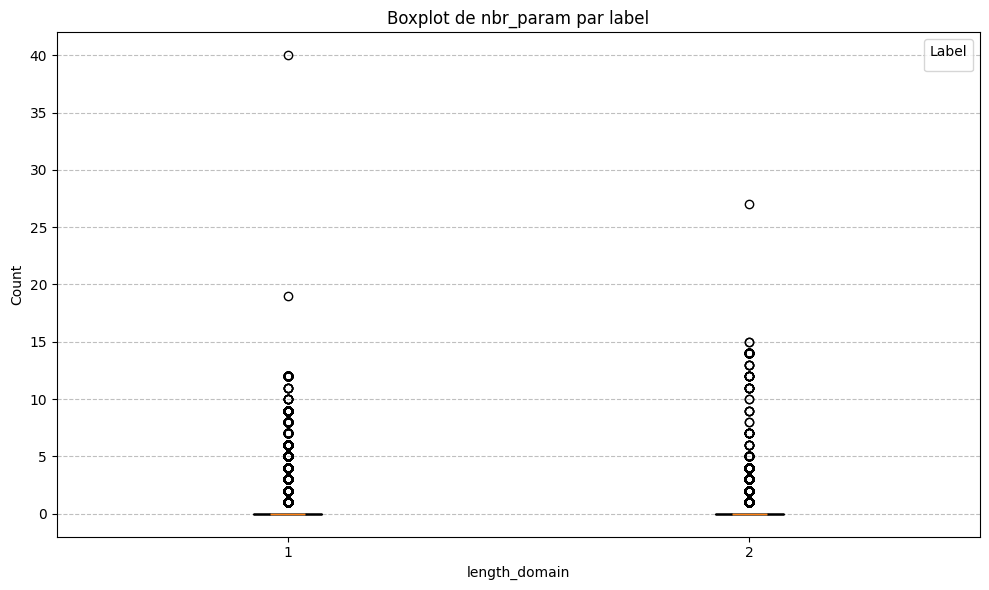

In [88]:
df_carc['nbr_param'] = df['domain'].apply(lambda i : count_query_parameters(i))

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([df_carc[df_carc['label'] == 0]["nbr_param"], df_carc[df_carc['label'] == 1]["nbr_param"]], patch_artist=True, notch=True)

ax.yaxis.grid(True, linestyle='--', which='both', color='grey', alpha=0.5)
ax.set_title(f'Boxplot de nbr_param par label')
ax.set_xlabel("length_domain")
ax.set_ylabel('Count')
ax.legend(title='Label')

plt.tight_layout()
plt.show()

### Features & target

Sélection des caractérisques pouvant aider à la prédiction 

In [37]:
df_carc.columns

Index(['domain', 'label', 'nbr_https', 'nbr_http', 'nbr_doubleSlash',
       'nbr_www', 'nbr_slash', 'nbr_@', 'nbr_-', 'nbr_?', 'nbr_%', 'nbr_=',
       'nbr_.', 'length', 'phishing_words', 'ip_address', 'G_index',
       'cont_digit', 'length_domain', 'short_url', 'bad_url', 'nbr_spe_c',
       'hexa', 'nbr_param'],
      dtype='object')

In [38]:
X = df_carc[['nbr_https', 'nbr_http', 'nbr_doubleSlash',
       'nbr_www', 'nbr_slash', 'nbr_@', 'nbr_-', 'nbr_?', 'nbr_%', 'nbr_=',
       'nbr_.', 'length', 'phishing_words',
       'cont_digit', 'length_domain', 'short_url', 'bad_url', 'nbr_spe_c',
       'hexa', 'nbr_param']]

y = df['label']

### Train test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True)

### Models

### Random Forest Classifier

In [40]:
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')

In [41]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
y_pred_rf = rf.predict(X_test)

In [43]:
print(classification_report(y_test,y_pred_rf,target_names=['legitime','phishing']))

score = accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)
r_score = recall_score(y_test, y_pred_rf)
print("recall:   %0.3f" % r_score)

              precision    recall  f1-score   support

    legitime       0.96      0.97      0.96     18536
    phishing       0.90      0.86      0.88      5662

    accuracy                           0.94     24198
   macro avg       0.93      0.92      0.92     24198
weighted avg       0.94      0.94      0.94     24198

accuracy:   0.945
recall:   0.863


<Figure size 800x600 with 0 Axes>

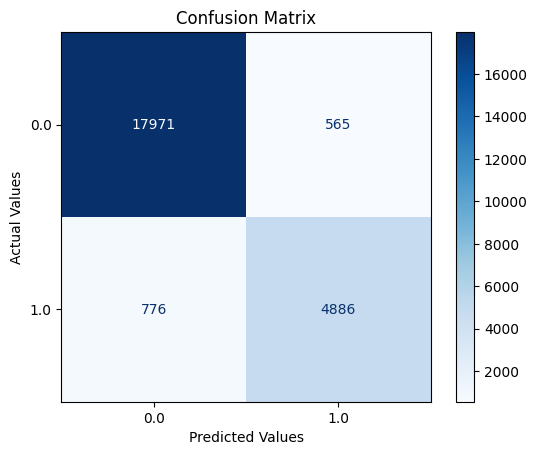

In [44]:
cm = confusion_matrix(y_test, y_pred_rf)
#cm_df = pd.DataFrame(cm,
#                     index = ['legitime','phishing'], 
#                     columns = ['legitime','phishing'])
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Affichons à présent l'importance des features dans la prédiction de phishing

<Axes: >

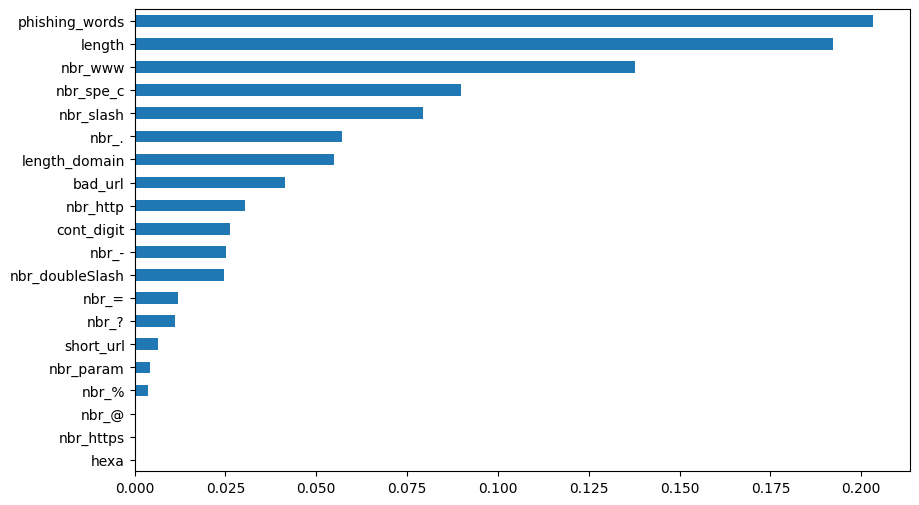

In [45]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

### Logistic regression

In [46]:
lr = LogisticRegression(max_iter=1000)

In [47]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [48]:
y_pred_lr = lr.predict(X_test)

              precision    recall  f1-score   support

    legitime       0.91      0.97      0.94     18536
    phishing       0.87      0.67      0.76      5662

    accuracy                           0.90     24198
   macro avg       0.89      0.82      0.85     24198
weighted avg       0.90      0.90      0.89     24198

accuracy:   0.899
recall:   0.670


<Figure size 800x600 with 0 Axes>

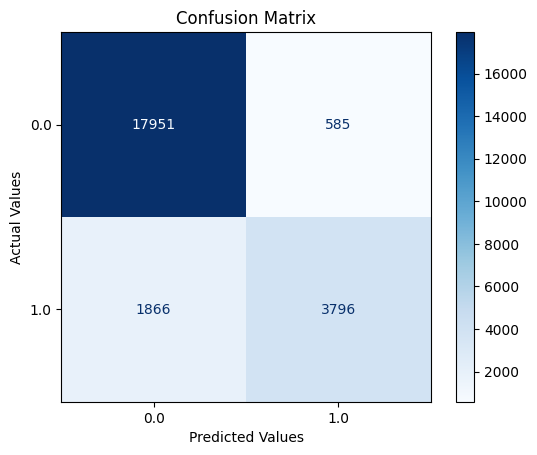

In [49]:
print(classification_report(y_test,y_pred_lr,target_names=['legitime','phishing']))

score = accuracy_score(y_test, y_pred_lr)
print("accuracy:   %0.3f" % score)
r_score = recall_score(y_test, y_pred_lr)
print("recall:   %0.3f" % r_score)

cm = confusion_matrix(y_test, y_pred_lr)
#cm_df = pd.DataFrame(cm,
#                     index = ['legitime','phishing'], 
#                     columns = ['legitime','phishing'])
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### XGBOOST

In [50]:
x = XGBClassifier(n_estimators= 100)

In [51]:
x.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [52]:
y_pred_x = x.predict(X_test)

              precision    recall  f1-score   support

    legitime       0.96      0.98      0.97     18536
    phishing       0.91      0.86      0.88      5662

    accuracy                           0.95     24198
   macro avg       0.93      0.92      0.92     24198
weighted avg       0.95      0.95      0.95     24198

accuracy:   0.947
recall:   0.856


<Figure size 800x600 with 0 Axes>

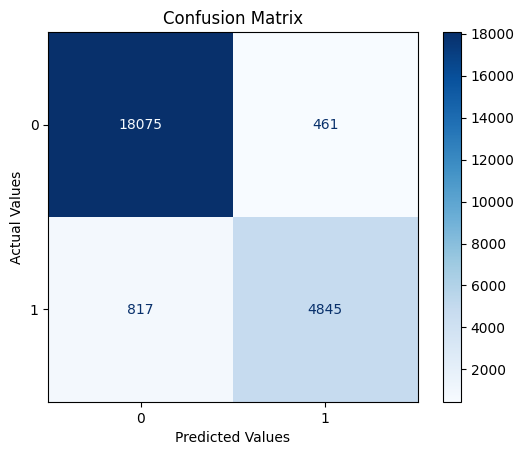

In [90]:
print(classification_report(y_test,y_pred_x,target_names=['legitime','phishing']))

score = accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)
r_score = recall_score(y_test, y_pred_x)
print("recall:   %0.3f" % r_score)

cm = confusion_matrix(y_test, y_pred_x)
#cm_df = pd.DataFrame(cm,
#                     index = ['legitime','phishing'], 
#                     columns = ['legitime','phishing'])
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=x.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Affichons ici les importances des features lors de la prédiction

<Axes: >

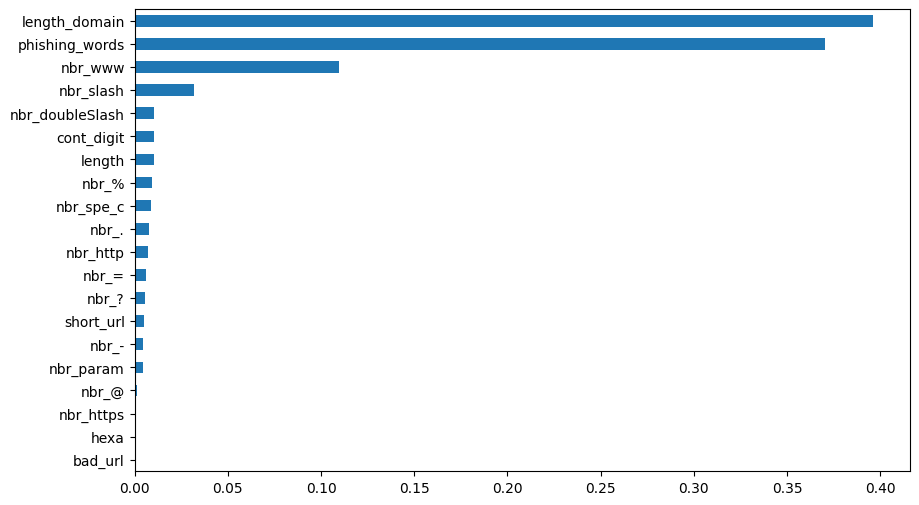

In [54]:
feat_importances = pd.Series(x.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

## Stacking

Création d'un model de stacking utilisant XGBOOST et RF. La combinaison de ces deux permet de couvrir un large éventail de caractéristiques des données, améliorant la capacité générale du modèle à généraliser.

En utilisant la logistique regression en tant que modèle méta, il peut pondérer efficacement les prédictions des modèles de base (XGBoost et RandomForest) pour produire une prédiction finale.

In [55]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100,max_features='sqrt')),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

In [56]:
# Définir le modèle méta
meta_model = LogisticRegression()

In [57]:
# Créer le classificateur de stacking
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=KFold(n_splits=2))

In [58]:
# Entraîner le modèle de stacking
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=KFold(n_splits=2, random_state=RandomState(MT19937) at 0x7FA7FF068440,
   shuffle=False),
                   estimators=[('rf', RandomForestClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_m...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [59]:
# Prédire sur le jeu de test
y_pred = stacking_clf.predict(X_test)

In [91]:
print(classification_report(y_test,y_pred,target_names=['legitime','phishing']))

score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)
r_score = recall_score(y_test, y_pred)
print("recall:   %0.3f" % r_score)

              precision    recall  f1-score   support

    legitime       0.96      0.98      0.97     18536
    phishing       0.91      0.85      0.88      5662

    accuracy                           0.95     24198
   macro avg       0.94      0.92      0.92     24198
weighted avg       0.95      0.95      0.95     24198

accuracy:   0.947
recall:   0.854


In [61]:
stacking_clf.classes_

array([0., 1.])

<Figure size 800x600 with 0 Axes>

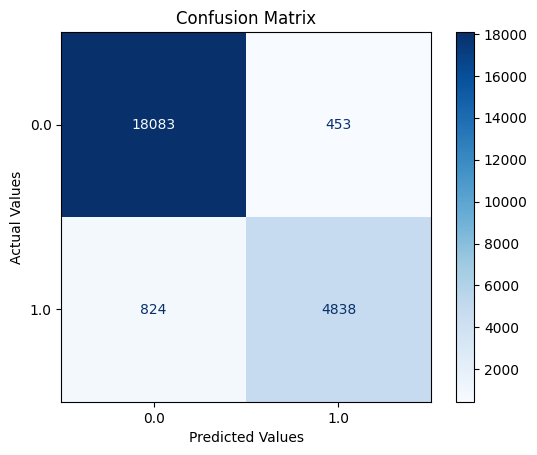

In [62]:
cm = confusion_matrix(y_test, y_pred)
#cm_df = pd.DataFrame(cm,
#                     index = ['legitime','phishing'], 
#                     columns = ['legitime','phishing'])
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## Test de prédiction utilisant les données textuelles
j'ai choisi de surveiller principalement le Recall (ou rappel) comme métrique de performance clé car il est plus dangereux pour un utilisateur que le model prédise qu'un email est légitime alors qu'il est du fishing. Le Recall mesure la capacité du modèle à identifier correctement toutes les instances positives (c'est-à-dire les URL de phishing). Et lors de cette phase de test j'ai constaté que le recall etait faible malgré un fort taux de précision. Ce qui m'a poussé à utiliser les caractéristiques numériques.

### Methode à l'aide de la tokenisation

In [63]:
def remove_spe_car(url):
    tokens = re.split('[/-]', url)
    
    while '' in tokens:
         tokens.remove('')
         
    return tokens

In [64]:
XVec_train, XVec_test, y_vtrain, y_vtest = train_test_split(df['domain'], y, stratify=y, test_size=0.2,shuffle=True)

In [65]:
vec = CountVectorizer(tokenizer=remove_spe_car)

vec_train = vec.fit_transform(XVec_train)

/Users/sergekeita/opt/anaconda3/envs/mailinblack/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [66]:

vec_test = vec.transform(XVec_test)

## Models

In [67]:
v_rf = RandomForestClassifier(n_estimators=100)

In [68]:
v_rf.fit(vec_train,y_vtrain)

RandomForestClassifier()

In [69]:
y_pred_vr = v_rf.predict(vec_test)

              precision    recall  f1-score   support

    legitime       0.91      0.99      0.95     18536
    phishing       0.98      0.69      0.81      5662

    accuracy                           0.92     24198
   macro avg       0.94      0.84      0.88     24198
weighted avg       0.93      0.92      0.92     24198

accuracy:   0.924
recall:   0.691


<Figure size 800x600 with 0 Axes>

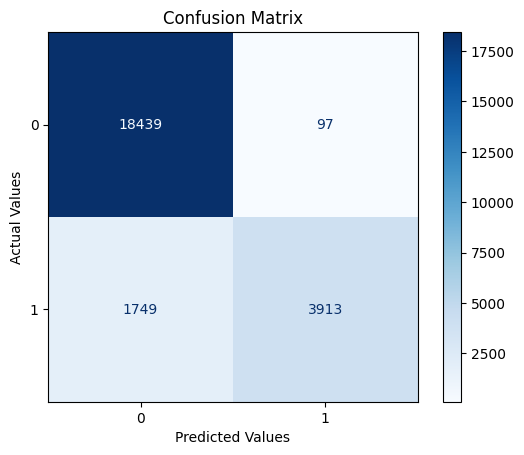

In [70]:
print(classification_report(y_vtest,y_pred_vr,target_names=['legitime','phishing']))

score = accuracy_score(y_vtest, y_pred_vr)
print("accuracy:   %0.3f" % score)
r_score = recall_score(y_vtest, y_pred_vr)
print("recall:   %0.3f" % r_score)

cm = confusion_matrix(y_vtest, y_pred_vr)
#cm_df = pd.DataFrame(cm,
#                     index = ['legitime','phishing'], 
#                     columns = ['legitime','phishing'])
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=x.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [71]:
v_lr = LogisticRegression(solver='lbfgs')

In [72]:
v_lr.fit(vec_train,y_vtrain)

LogisticRegression()

In [73]:
y_pred_vl = v_lr.predict(vec_test)

              precision    recall  f1-score   support

    legitime       0.91      1.00      0.95     18536
    phishing       0.98      0.68      0.80      5662

    accuracy                           0.92     24198
   macro avg       0.94      0.84      0.88     24198
weighted avg       0.93      0.92      0.92     24198

accuracy:   0.922
recall:   0.681


<Figure size 800x600 with 0 Axes>

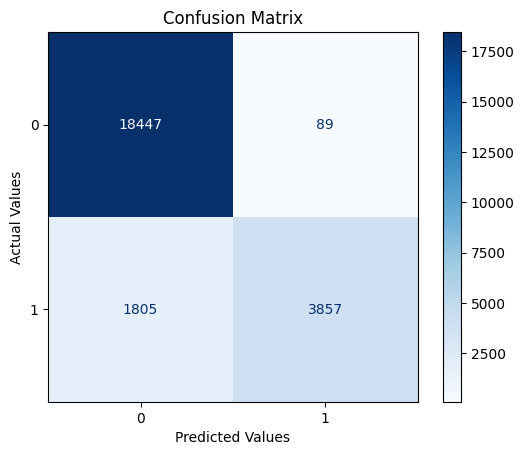

In [95]:
print(classification_report(y_vtest,y_pred_vl,target_names=['legitime','phishing']))

score = accuracy_score(y_vtest, y_pred_vl)
print("accuracy:   %0.3f" % score)
r_score = recall_score(y_vtest, y_pred_vl)
print("recall:   %0.3f" % r_score)

cm = confusion_matrix(y_vtest, y_pred_vl)
#cm_df = pd.DataFrame(cm,
#                     index = ['legitime','phishing'], 
#                     columns = ['legitime','phishing'])
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=x.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()